# Using LDA for Topic Modeling

Add LDA description here.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer


## Load Data

In [ ]:
# load cleaned and preprocessed data
data = pd.read_csv('../data/cleaned_data/cleaned_processed_data.csv')
data.head()

## Additional Cleaning

Further cleaning is necessary to come up with better results in choosing topics.

In [3]:
# remove rows containg NaN value

nan_in_context = data['Content'].isna()
num_nans = data['Content'].isna().sum()
print(num_nans)

data.dropna(subset=['Content'], inplace=True)
data.reset_index(drop=True, inplace=True)

data['ID'] = range(len(data))

data

1


,Content,ID
0,congressional republican new fear come health ...,0
1,bullet shell get counted blood dry votive cand...,1
2,walt disney bambi opened critic praised spare ...,2
3,death may great equalizer isnt necessarily eve...,3
4,north korea leader kim said sunday country mak...,4
...,...,...
148865,program beat dialler scam introducing two init...,148865
148866,spam email tempt net shopper computer user acr...,148866
148867,careful code new european directive could put ...,148867
148868,cyber security chief resigns man making sure c...,148868


In [4]:
# observed that '_' was not removed. Further cleaning process
import re

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text) # remove punctuations
    text = re.sub(r'_', '', text)
    return text

data['Content'] = data['Content'].apply(clean_text)


## Using TF-IDF scores and Gensim's dictionary to further preprocess the data

In [5]:
import pyLDAvis.gensim_models
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [6]:
# Using TF-IDF scores and gensim's Dictionary to further preprocess the data

corpus = data['Content'].tolist()
tokenized_docs = [article.split() for article in corpus]

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# This returns words in the order they appear in the tfidf_matrix
feature_names = tfidf_vectorizer.get_feature_names_out()

# Take the maximum TF-IDF score across all documents for each word to identify the
# hightest importance that each word has in any single document.
tfidf_scores = tfidf_matrix.max(axis=0).toarray()[0]

# experimenting with threshold values.
threshold = np.mean(tfidf_scores)

word_tfidf_dict = dict(zip(feature_names, tfidf_scores))

filtered_tokenized_docs = []
for doc in tokenized_docs:
    # filter out using TF-IDF threshold
    filtered_doc = [word for word in doc if word_tfidf_dict.get(word, 0) >= threshold]
    filtered_tokenized_docs.append(filtered_doc)

# Here, we use gensim's Dictionary to filter out extremes.
# According to ChatGPT, it calculates the document frequency for each word, and use that to filter out extremes.
tokenized_docs = filtered_tokenized_docs
dictionary = Dictionary(tokenized_docs)

dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_docs]

## Finding the optimal number of topics using coherence score

In [8]:
# compute coherence score using C_v to find opt number of topics.

topic = []
score = []

# to choose opt number of topics, I ran from 1 ~ 10 number of topics to compare coherence score.
# There are many ways to calculate coherence score, but I chose to go with the most genearlized one, which is c_v score.
# I put number of workers same as the number of cores for my device.
# I read few articles, and learned that c_v score of 0.5 is good.
for i in tqdm(range(1,11)):
    lda_model = LdaMulticore(corpus=doc_term_matrix, id2word=dictionary,
                        iterations=10, num_topics=i, workers=8, passes=10, chunksize=1000,random_state=100)
    cm = CoherenceModel(model=lda_model, texts=tokenized_docs,
                       corpus=doc_term_matrix, coherence='c_v')
    topic.append(i)
    score.append(cm.get_coherence())


100%|██████████| 10/10 [25:56<00:00, 155.67s/it]


AttributeError: module 'matplotlib' has no attribute 'plot'

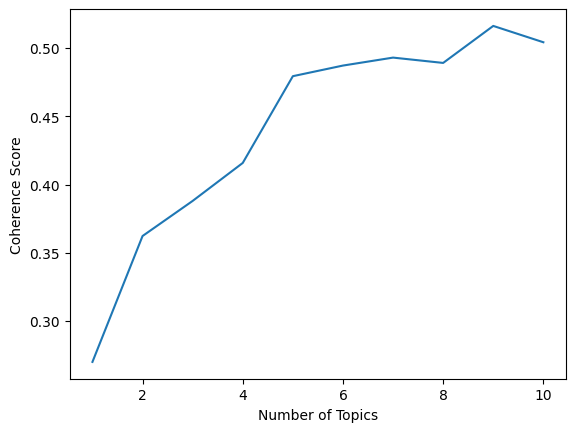

In [10]:
plt.plot(topic, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

## LDA Model

In [11]:
lda_model_opt = LdaMulticore(corpus=doc_term_matrix, id2word=dictionary,
                        iterations=50, num_topics=7, workers=8, passes=50, random_state=100)



lda_model_opt.print_topics(-1)

[(0,
  '0.043*"trump" + 0.014*"clinton" + 0.012*"republican" + 0.009*"campaign" + 0.008*"election" + 0.008*"party" + 0.008*"donald" + 0.007*"president" + 0.007*"state" + 0.007*"voter"'),
 (1,
  '0.010*"state" + 0.009*"country" + 0.007*"government" + 0.006*"united" + 0.006*"president" + 0.006*"military" + 0.005*"attack" + 0.005*"war" + 0.005*"force" + 0.004*"group"'),
 (2,
  '0.008*"say" + 0.005*"health" + 0.005*"study" + 0.004*"water" + 0.004*"could" + 0.004*"university" + 0.003*"drug" + 0.003*"climate" + 0.003*"research" + 0.003*"food"'),
 (3,
  '0.009*"game" + 0.007*"team" + 0.006*"first" + 0.005*"player" + 0.005*"season" + 0.004*"last" + 0.004*"two" + 0.004*"film" + 0.004*"show" + 0.004*"play"'),
 (4,
  '0.015*"company" + 0.009*"percent" + 0.007*"million" + 0.006*"market" + 0.006*"business" + 0.006*"billion" + 0.004*"tax" + 0.004*"price" + 0.004*"bank" + 0.004*"last"'),
 (5,
  '0.010*"like" + 0.008*"say" + 0.006*"woman" + 0.005*"thing" + 0.005*"way" + 0.005*"dont" + 0.005*"think" + 

In [26]:
lda_model_opt.save("lda_model_9")

## Visualize Topics

In [17]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model_opt, doc_term_matrix, dictionary)
pyLDAvis.display(lda_display)

# Observing Result

In [ ]:
# Just wanted to check out if each topics made sense for certain readme files
n = 3
print(lda_model_opt[doc_term_matrix][n])
print(data['Content'].tolist()[n])